# XGBoost

### XGBoost Overview

**XGBoost** (eXtreme Gradient Boosting) is a machine learning algorithm that is efficient and scalable for tasks like classification and regression. It is an implementation of gradient-boosted decision trees designed for high performance.

#### Key Features
- **Gradient Boosting**: Sequentially builds models to correct errors of previous ones.
- **Regularization**: L1 and L2 regularization to prevent overfitting.
- **Missing Values**: Handles missing data internally.
- **Parallel Processing**: Optimized for speed using hardware resources.
- **Tree Pruning**: Uses depth-first approach to prune trees.

#### How XGBoost Works
1. **Initialization**: Start with an initial prediction (e.g., mean for regression).
2. **Residuals**: Compute the error (residuals).
3. **Fit Tree**: Fit a decision tree to the residuals.
4. **Update**: Update the prediction by adding the new tree.
5. **Repeat**: Continue until error is minimized.

#### Important Parameters
- **Learning Rate (eta)**: Controls contribution of each tree.
- **Max Depth (max_depth)**: Maximum depth of each tree.
- **Subsample**: Fraction of data used per tree.
- **Colsample_bytree**: Fraction of features used per tree.
- **n_estimators**: Number of boosting rounds.

#### Objective Function

The model minimizes the following objective function:

$$
\text{Obj} = \sum_{i=1}^{n} L(y_i, \hat{y}_i^{(t)}) + \sum_{t=1}^{T} \Omega(f_t)
$$

Where the first part is the loss function, and the second part is the regularization term.


Lets start with our first exercise! We will be training a XGBoost Classifier to try to predict whether a certain individual had an income of greater than 50,000 based on their demographic information.

# 1. Load Data

In [1]:
import numpy as np
import pandas as pd

In [2]:
train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', skiprows = 1, header = None) # Make sure to skip a row for the test set

In [3]:
train_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
test_set.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


# 2. Data Preprocessing

I notice a few problems immediately:

- We don't have a column header for our data
- There are unknown values in our test set (the question marks) that we need to deal with
- The target values have periods at the end in the test set but do not in the training set ("<=50K." != "<=50K")

In the dataset description, we can see the column names.

In [5]:
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']

In [6]:
train_set.columns = col_labels
test_set.columns = col_labels

In [7]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  wage_class      32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [8]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  int64 
 1   workclass       16281 non-null  object
 2   fnlwgt          16281 non-null  int64 
 3   education       16281 non-null  object
 4   education_num   16281 non-null  int64 
 5   marital_status  16281 non-null  object
 6   occupation      16281 non-null  object
 7   relationship    16281 non-null  object
 8   race            16281 non-null  object
 9   sex             16281 non-null  object
 10  capital_gain    16281 non-null  int64 
 11  capital_loss    16281 non-null  int64 
 12  hours_per_week  16281 non-null  int64 
 13  native_country  16281 non-null  object
 14  wage_class      16281 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


Hmm. There don't seem to be any. According to the accompanying notes, the original datasets had 32561 in train and 16281 with test. However, unknowns are included and have been labeled with a question mark (?). The test results documented were done after removing all unknowns. Therefore, to see if we can beat their best results, we need to remove the same unknown rows. 

If we do so, we should have 30162 in train and 15060 in test. Let's see if we can remove all of these unknown rows. 

It turns out the question mark was actually entered with a space first. Let's do a simple test to see what would happen if we dropped all rows that contain an unknown marked with a ' ?'.

In [9]:
train_set.replace(' ?', np.nan).dropna().shape

(30162, 15)

In [10]:
test_set.replace(' ?', np.nan).dropna().shape

(15060, 15)

In [11]:
train_nomissing = train_set.replace(' ?', np.nan).dropna()
test_nomissing = test_set.replace(' ?', np.nan).dropna()

Now that we have taken care of the missing value problem, we still have an issue with the target income thresholds being encoded slightly differently in test vs. train. We need these to match up appropriately, so we are going to need to fix either the test or training set to make them match up. Let's replace all of the '<=50K.' with '<=50K' and the same for '>50K.' with '>50K'. This is also encoded with a space so include this in the string. We can use the replace method from pandas to fix this. 

In [12]:
test_nomissing['wage_class'] = test_nomissing.wage_class.replace({' <=50K.': ' <=50K', ' >50K.':' >50K'})

#### Ordinal Encoder or One-Hot Encoder ?

Our next step is to encode the features with a string category since XGBoost (like all of the other machine learning algorithms in Python) requires every feature vector to include only digits. To do this properly, however, we will need to join the two together and apply our encoding so that the same categories exist in both datasets when we do train/test evaluation. 

There is some debate as to whether you are technically supposed to use one-hot encoding for categorical features (since there isn't supposed to be any inherent ordering) or you can use ordinal encoder. My master's Machine Learning teacher Han found [this discussion](https://github.com/szilard/benchm-ml/issues/1) on the subject, that I found really interesting. It seems that one-hot encoding isn't necessary for tree-based algorithms, but you may run into a problem using this on linear models. Let's test them both and see it for ourselves!


In [13]:
data = pd.concat([train_nomissing, test_nomissing], axis = 0) # Stacks them vertically

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45222 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45222 non-null  int64 
 1   workclass       45222 non-null  object
 2   fnlwgt          45222 non-null  int64 
 3   education       45222 non-null  object
 4   education_num   45222 non-null  int64 
 5   marital_status  45222 non-null  object
 6   occupation      45222 non-null  object
 7   relationship    45222 non-null  object
 8   race            45222 non-null  object
 9   sex             45222 non-null  object
 10  capital_gain    45222 non-null  int64 
 11  capital_loss    45222 non-null  int64 
 12  hours_per_week  45222 non-null  int64 
 13  native_country  45222 non-null  object
 14  wage_class      45222 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


In [15]:
# We ransform 'wage_class' column into binary to be our target and drop the non binary column
data['wage_class_binary'] = data['wage_class'].apply(lambda x: 1 if x == ' >50K' else 0)
data = data.drop(columns='wage_class')

In [16]:
X = data.drop(columns='wage_class_binary')
y = data['wage_class_binary']

We will be using a pipeline code I developed has a template and just do the necessary minor changes 

In [17]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

#### Ordinal Encoder

In [18]:
### PIPELINE ###

# Standard Scaler is not needed because:
# Tree-based models (like decision trees, random forests, and gradient boosting) are generally invariant to feature scaling.
# XGBoost's underlying decision trees can handle unscaled data effectively without performance loss.

# Simple Imputer is not needed because:
# XGBoost automatically learns the best way to handle missing values while building trees.

numerical_features = [
    'age',
    'fnlwgt',
    'education_num',
    'capital_gain',
    'capital_loss',
    'hours_per_week',
]

categorical_features = [
    'workclass',
    'education',
    'marital_status',
    'occupation', 
    'relationship',
    'race',
    'sex',
    'native_country'
]

preprocessor = ColumnTransformer(
    transformers=[
        # ('num', Pipeline(steps=[
            # ('imputer', SimpleImputer(strategy='mean')),
            # ('scaler', StandardScaler())
        # ]), numerical_features),
        ('cat', Pipeline(steps=[
            # ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder())
        ]), categorical_features)
    ])

X_categorical = X.copy()
X_categorical[categorical_features] = X_categorical[categorical_features].astype('category')

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_ordinal = pipeline.fit_transform(X_categorical)

#### One-Hot Encoder

In [19]:
### PIPELINE ###

# Standard Scaler is not needed because:
# Tree-based models (like decision trees, random forests, and gradient boosting) are generally invariant to feature scaling.
# XGBoost's underlying decision trees can handle unscaled data effectively without performance loss.

# Simple Imputer is not needed because:
# XGBoost automatically learns the best way to handle missing values while building trees.

numerical_features = [
    'age',
    'fnlwgt',
    'education_num',
    'capital_gain',
    'capital_loss',
    'hours_per_week',
]

categorical_features = [
    'workclass',
    'education',
    'marital_status',
    'occupation', 
    'relationship',
    'race',
    'sex',
    'native_country'
]

preprocessor = ColumnTransformer(
    transformers=[
        # ('num', Pipeline(steps=[
            # ('imputer', SimpleImputer(strategy='mean')),
            # ('scaler', StandardScaler())
        # ]), numerical_features),
        ('cat', Pipeline(steps=[
            # ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_one_hot = pipeline.fit_transform(X)

In [20]:
# Usually we would use train_test_split but in this case we can use the shape of the train & test sets 
# from before to keep the same rows in each set and be true to the exercise. Not that anybody cares.

# X = data.drop(columns='wage_class_binary')
# y = data['wage_class_binary']

# X_train, X_test, y_train, y_test = train_test_split(processed_data, y, test_size=0.2, random_state=42, stratify=y)

X_one_hot_train = X_one_hot[:train_nomissing.shape[0]] # Up to the last initial training set row
X_ordinal_train = X_ordinal[:train_nomissing.shape[0]] # Up to the last initial training set row
y_train = y[:train_nomissing.shape[0]] # Up to the last initial training set row

X_one_hot_test = X_one_hot[train_nomissing.shape[0]:] # Up to the last initial training set row
X_ordinal_test = X_ordinal[train_nomissing.shape[0]:] # Up to the last initial training set row
y_test = y[train_nomissing.shape[0]:]# Up to the last initial training set row


# 3. Model Training

First of all lets check y to see if we are dealing with class imbalance or not.

In [21]:
y_train.value_counts(dropna=False)

wage_class_binary
0    22654
1     7508
Name: count, dtype: int64

We do have some class imbalance, we should take note and take it into account when defining our model

In [22]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import (precision_recall_curve, confusion_matrix, 
                             classification_report, roc_auc_score, 
                             average_precision_score)
import matplotlib.pyplot as plt
import seaborn as sns
import time


When thre is class imbalance, we should lower the learning rate and increase the max_depth, num_boost_rounds & early_stopping_rounds to let the model learn slower and for longer time to pick more carachteristics on the lower sampled class. This risk overfitting of course so its recommended to test some combination and see how the model deals with the data in hand.

In [23]:
def custom_grid_search_cv_xgb(X_train, y_train, X_test, y_test):
    # This method of grid search enables us to use the cv function of xgb package to handle early stopping 
    # while at the same time tuning the hyperparameters of the model

    start_time = time.time()
    scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

    # Convert data to DMatrix: optimize both memory efficiency and computational speed
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

    # Define ranges for hyperparameter tuning
    param_grid = {
        'max_depth': [3, 5, 7, 9],
        'min_child_weight': [1, 3, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }

    # Setup StratifiedKFold
    skf = StratifiedKFold(n_splits = 3, shuffle= True, random_state=42)

    # Variables to track the best score and parameters
    best_params = None
    best_aucpr = 0

    # Loop through all combinations of hyperparameters
    for max_depth in param_grid['max_depth']:
        for min_child_weight in param_grid['min_child_weight']:
            for learning_rate in param_grid['learning_rate']:
                for subsample in param_grid['subsample']:
                    for colsample_bytree in param_grid['colsample_bytree']:
                        params = {
                            'objective': 'binary:logistic',
                            'eval_metric': 'aucpr',
                            'scale_pos_weight': scale_pos_weight,
                            'max_depth': max_depth,
                            'eta': learning_rate,
                            'subsample': subsample,
                            'colsample_bytree': colsample_bytree,
                            'min_child_weight': min_child_weight,
                            'random_state': 42
                        }
    
                        # Cross-validation 
                        cv_results = xgb.cv(
                            params,
                            dtrain,
                            num_boost_round=2000, # number of boosting rounds aka trees to build
                            folds=skf,
                            early_stopping_rounds=50, # Validation metric needs to improve at least once in every 
                                                        # early_stopping_rounds round(s) to continue training
                                                        # Overfitting prevention *
                            metrics='aucpr', # given the slight class imbalance and the nature of the problem 
                                            # I believe a good metric to judge the quality of our model
                            as_pandas=True,
                            seed=42,
                            verbose_eval=False
                        )
    
                        # Get the best score for the current combination of hyperparameters
                        mean_aucpr = cv_results['test-aucpr-mean'].max()
                        boost_rounds = cv_results['test-aucpr-mean'].idxmax()
    
                        if mean_aucpr > best_aucpr:
                            best_aucpr = mean_aucpr
                            best_params = params
                            best_boost_rounds = boost_rounds
                            print('NEW BEST!')
    
                        print(f"Test AUC-PR Mean: {mean_aucpr}, Boost Rounds: {boost_rounds}, Params: {params}")

    final_model = xgb.train(
        best_params,
        dtrain,
        num_boost_round=best_boost_rounds
    )

    y_pred_prob = final_model.predict(dtest)
    
    # Optimize threshold based on Precision-Recall curve
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob)
    optimal_idx = np.argmax(precisions + recalls)
    optimal_threshold = thresholds[optimal_idx]

    y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

    # Confusion Matrix
    cm_rf = confusion_matrix(y_test, y_pred_optimal)
    class_names = ['Class 0', 'Class 1']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - XGBoost')
    plt.show()

    # Classification report and ROC
    print('Classification Report:')
    print(classification_report(y_test, y_pred_optimal))

    roc_auc = roc_auc_score(y_test, y_pred_prob)
    print('ROC-AUC Score:')
    print(roc_auc)

    pr_auc = average_precision_score(y_test, y_pred_prob)
    print('PR AUC Score:')
    print(pr_auc)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time taken: {elapsed_time:.2f} seconds")

    return final_model



NEW BEST!
Test AUC-PR Mean: 0.6924131602476203, Boost Rounds: 1218, Params: {'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'scale_pos_weight': 3.017314864144912, 'max_depth': 3, 'eta': 0.01, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 1, 'random_state': 42}
Test AUC-PR Mean: 0.692129571213178, Boost Rounds: 990, Params: {'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'scale_pos_weight': 3.017314864144912, 'max_depth': 3, 'eta': 0.01, 'subsample': 0.6, 'colsample_bytree': 0.8, 'min_child_weight': 1, 'random_state': 42}
NEW BEST!
Test AUC-PR Mean: 0.6942533860375996, Boost Rounds: 1466, Params: {'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'scale_pos_weight': 3.017314864144912, 'max_depth': 3, 'eta': 0.01, 'subsample': 0.6, 'colsample_bytree': 1.0, 'min_child_weight': 1, 'random_state': 42}
NEW BEST!
Test AUC-PR Mean: 0.6942819814468688, Boost Rounds: 1767, Params: {'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'scale_pos_weight'

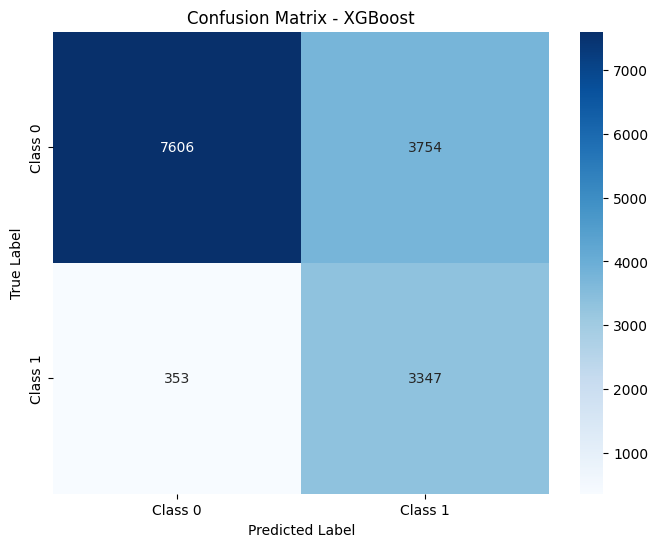

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     11360
           1       0.47      0.90      0.62      3700

    accuracy                           0.73     15060
   macro avg       0.71      0.79      0.70     15060
weighted avg       0.84      0.73      0.75     15060

ROC-AUC Score:
0.875977291111534
PR AUC Score:
0.6868902329054343
Total time taken: 4411.28 seconds


In [24]:
model_ordinal = custom_grid_search_cv_xgb(X_ordinal_train, y_train, X_ordinal_test, y_test)
model_ordinal

NEW BEST!
Test AUC-PR Mean: 0.6974070983335269, Boost Rounds: 1509, Params: {'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'scale_pos_weight': 3.017314864144912, 'max_depth': 3, 'eta': 0.01, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 1, 'random_state': 42}
Test AUC-PR Mean: 0.6969709183365893, Boost Rounds: 1335, Params: {'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'scale_pos_weight': 3.017314864144912, 'max_depth': 3, 'eta': 0.01, 'subsample': 0.6, 'colsample_bytree': 0.8, 'min_child_weight': 1, 'random_state': 42}
Test AUC-PR Mean: 0.6949587416976026, Boost Rounds: 1063, Params: {'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'scale_pos_weight': 3.017314864144912, 'max_depth': 3, 'eta': 0.01, 'subsample': 0.6, 'colsample_bytree': 1.0, 'min_child_weight': 1, 'random_state': 42}
Test AUC-PR Mean: 0.6954146926399366, Boost Rounds: 1175, Params: {'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'scale_pos_weight': 3.01731486414491

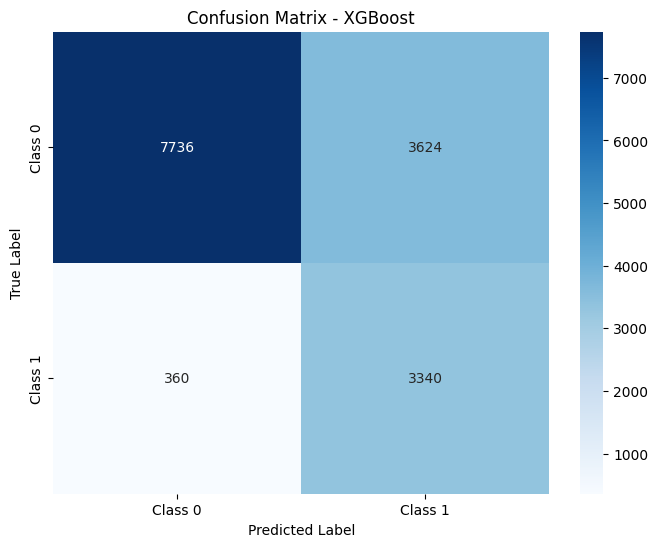

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     11360
           1       0.48      0.90      0.63      3700

    accuracy                           0.74     15060
   macro avg       0.72      0.79      0.71     15060
weighted avg       0.84      0.74      0.75     15060

ROC-AUC Score:
0.8764235463456413
PR AUC Score:
0.6872299074571434
Total time taken: 3702.48 seconds


In [25]:
model_one_hot = custom_grid_search_cv_xgb(X_one_hot_train, y_train, X_one_hot_test, y_test)
model_one_hot

After this test we arrived to the conclusion that both methods built good models, different but close in quality. Nevertheless, one-hot encoding ended up taking more time as predicted and does take more computer capacity, this difference will be increased if there are more categorical features in our dataset. Ordinal encoding didn't show any signal of inferiority and all the signs of higher perfomance so I recommend anyone that could be reading to take a look at it!